# Homework 4 - Recommendation systems and clustering everywhere

#### Group 8 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>Gloria Kim</td>
            <td>keemgloria</td>
            <td>1862339</td>
            <td>kim.1862339@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Alessandra Colaiocco</td>
            <td>Alessandra9922</td>
            <td>1843714</td>
            <td>colaiocco.1843714@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Giuliana Prinzi</td>
            <td>1952137</td>
            <td>1952137</td>
            <td>prinzi.1952137@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Zakary Belkacem</td>
            <td>1952137</td>
            <td></td>
            <td>zakary.belkacem@edu.esiee.fr</td>
        </tr>
    </table>
</div>

## 1. Recommendation system

We will start by loading the csv data into a dataframe and then we will do some preprocessing 

In [18]:
import pandas as pd
from typing import List
import pandas as pd
import random


In [22]:
pd.set_option("display.max_colwidth", None)

# Load data
data = pd.read_csv("vodclickstream_uk_movies_03.csv")

# We convert datetime column to a date
data.datetime = pd.to_datetime(data.datetime)

# We convert release_date column to a date
data.release_date = pd.to_datetime(data.release_date, errors="coerce")

# We don't need the Row ID column
data.drop(data.columns[0], axis=1, inplace=True)

# Extract genres column to a new column genre_list that includes a list with all genres
data["genre_list"] = data.genres.apply(lambda row: [word.strip() for word in row.split(",")])

The function get_top_movies takes a user ID as input and extracts the top 10 most clicked movies for that user.
It filters the dataframe to include only rows associated with the given user, then groups the data by movie ID, title, and genres.
The resulting dataframe is sorted based on the number of clicks, and the top 10 movies are selected.
The function returns a dataframe with information about the top 10 movies for the specified user.

In [23]:
def get_top_movies(user_id: str) -> pd.DataFrame:
    
    
    # Filter all movies for the given user
    user_movies = data[data["user_id"] == user_id]

    # Group the data by user, movie ID, title, and genres, and count the number of clicks for each movie
    user_movies = user_movies.groupby(["user_id", "movie_id", "title", "genres"]).size().reset_index(name="clicks")

    # Sort the movies based on the number of clicks in descending order and select the top 10
    top_10_user_movies = user_movies.sort_values(by="clicks", ascending=False).head(10)[["title", "genres", "clicks"]]

    # Reset the index of the dataframe for a cleaner structure
    top_10_user_movies.reset_index(drop=True, inplace=True)
    
    return top_10_user_movies

In [30]:
# Choose the user you want to see the top 10 movies regarding the clicks
user_id = "a41dd22654"

get_top_movies(user_id)

,title,genres,clicks
0,Elle,"Crime, Drama, Thriller",3
1,Derren Brown: The Push,NOT AVAILABLE,2
2,Science Fiction Volume One: The Osiris Child,"Action, Adventure, Drama, Fantasy, Horror, Sci-Fi, Thriller",2
3,ARQ,"Action, Sci-Fi, Thriller",2
4,Warcraft,"Action, Adventure, Fantasy",1
5,The Big Short,"Biography, Comedy, Drama, History",1
6,I Don't Feel at Home in This World Anymore,"Comedy, Crime, Drama, Thriller",1
7,Happy Anniversary,Comedy,1
8,Mute,"Mystery, Sci-Fi, Thriller",1
9,To All the Boys I've Loved Before,"Comedy, Drama, Romance",1


## 1.2 Minhash Signatures

In [32]:
# Retrieve a list with all unique genres
# We're using a set to collect unique genres from the data
# The %%capture is used to suppress output in Jupyter cells

%%capture
unique_genres = set()
data["genre_list"].apply(lambda row: [unique_genres.add(value) for value in row])


UsageError: Line magic function `%%capture` not found.


Retrieve Unique Genres and Encode Binary Representation

Purpose: Collect unique genres using a set and encode a binary representation of genres for each movie.

Explanation: A set is used to gather distinct genres, and the binary representation is created by assigning 1 if a genre is present and 0 otherwise.

In [33]:
# Encode the genre list (which we treat as our shingles) of every movie to a one-hot list
# We create a binary representation of genres for each movie
data["one_hot_genre_list"] = data["genre_list"].apply(
    lambda genre_list: [1 if genre in genre_list else 0 for genre in unique_genres]
)

Define Hash Function for Minhash

Purpose: Implement hash functions for generating Minhash signatures.

Explanation: Twelve hash functions are defined to calculate hash values based on specific formulas. These functions are crucial for creating Minhash signatures.

In [37]:
# Define hash function for Minhash
def hash_function(element: List) -> List:
   
    
    # Define the hash functions
    hash_functions = [
        lambda x: (x + 1) % 29,
        lambda x: (3*x + 1) % 83,
        lambda x: (2*x + 4) % 59,
        lambda x: (3*x - 1) % 83,
        lambda x: (x << 1) % 59,
        lambda x: (x >> 1) % 19,
        lambda x: (x << 2) % 109,
        lambda x: (x >> 2) % 11,
        lambda x: (x << 3) % 211,
        lambda x: (x >> 3) % 7,
        lambda x: (x << 4) % 421,
        lambda x: (x >> 4) % 5
    ]

    # Calculate hash values based on the defined functions
    hashes_result = [hash_fn(element) for hash_fn in hash_functions]

    return hashes_result

# Define Minhash function
def minhash(genre_list: List) -> List:
    
    
    # Create list of size 12 with 'inf' as the default value
    similarity_signature = [float("inf")]*12

    # Iterate through every element of the genre list
    for row_index, genre in enumerate(genre_list):
        # Calculate hash values of the current genre and skip if genre is not present
        if genre == 1:
            # Retrieve hash values of the current genre based on the row index
            hashes_result = hash_function(row_index)
            
            # Only update the similarity signature if a new hash value is smaller than the current one
            for i in range(0, 12):
                similarity_signature[i] = min(similarity_signature[i], hashes_result[i])

    return similarity_signature

Define Minhash Function

Purpose: Generate Minhash similarity signatures for movies based on their binary genre representation.

Explanation: The function initializes a list of 12 values with 'inf' as the default. It iterates through the binary genre list, calculates hash values, and updates the similarity signature if a new hash value is smaller.

In [38]:
# Create the minhash similarity signature for every movie
# Apply the Minhash function to the binary representation of genres
data["minhash"] = data["one_hot_genre_list"].apply(lambda genre_list: minhash(genre_list))

Define Custom Hash Function for LSH

Purpose: Create a custom hash function for the Locality-Sensitive Hashing (LSH) process.

Explanation: The function calculates a hash value for a given bucket of values. It uses a prime number and iterates through the bucket, updating the hash value.

Define LSH Function

Purpose: Apply Locality-Sensitive Hashing to Minhash signatures, creating LSH bands.

Explanation: The function divides the Minhash similarity signature into bands and calculates hash values for each band using the custom hash function. The resulting hash values form the LSH bands.

In [39]:
# Define custom hash function for LSH
def custom_hash(bucket: List) -> int:
    
    # Initialize hash value and prime number
    hash_value = 0
    prime_number = 41

    # Iterate through every value of the bucket
    for element in bucket:
        # Calculate hash value
        hash_value = (hash_value * prime_number) + element

    return hash_value

# Define LSH function
def lsh(similarity_signature: List, num_buckets: int, num_rows: int) -> List:
    
    # Create empty list
    band_hashes = []

    # Iterate through every bucket
    for bucket_start in range(0, len(similarity_signature), num_rows):
        # Extract current bucket
        bucket = similarity_signature[bucket_start:bucket_start + num_rows]
        
        # Calculate band hash for the current bucket
        band_hash = custom_hash(bucket) % 997
        
        # Append hash value to the final band
        band_hashes.append(band_hash)

    return band_hashes

#### Create LSH Bands for Every Movie

**Purpose**: Apply the LSH function to Minhash similarity signatures for each movie.

**Explanation**: The LSH function is applied to the Minhash similarity signatures, creating LSH bands for every movie. The number of buckets and rows is specified to control the granularity of the bands.

In [40]:
# Given number of buckets and number of rows
num_buckets = 4
num_rows = 3

# Create LSH band for every movie
# Apply the LSH function to the Minhash Similarity Signature
data["lsh_bands"] = data["minhash"].apply(lambda similarity_signature: lsh(similarity_signature, num_buckets, num_rows))

In [41]:
data

,datetime,duration,title,genres,release_date,movie_id,user_id,genre_list,one_hot_genre_list,minhash,lsh_bands
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 4, 32, 0, 0, 0, 0, 0, 0, 0, 0]","[729, 951, 0, 0]"
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]","[10, 28, 22, 26, 18, 4, 36, 2, 72, 1, 144, 0]","[34, 580, 850, 606]"
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[10, 28, 22, 26, 18, 4, 36, 2, 72, 1, 144, 0]","[34, 580, 850, 606]"
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[24, 70, 50, 68, 46, 11, 92, 5, 184, 2, 368, 1]","[393, 553, 506, 505]"
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, Fantasy",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family, Fantasy]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]","[1, 1, 4, 47, 0, 0, 0, 0, 0, 0, 0, 0]","[729, 244, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 13, 12, 11, 8, 2, 16, 1, 32, 0, 64, 0]","[974, 875, 50, 630]"
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci-Fi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]","[17, 49, 36, 47, 32, 8, 64, 4, 128, 2, 256, 1]","[712, 567, 200, 898]"
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]","[18, 52, 38, 50, 34, 8, 68, 4, 136, 2, 272, 1]","[524, 707, 950, 557]"
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[8, 22, 18, 20, 14, 3, 28, 1, 56, 0, 112, 0]","[410, 299, 306, 604]"


## 1.3 Locality-Sensitive Hashing (LSH)

#### Function to Retrieve Two Most Similar Users

This function aims to find the two most similar users to a given user based on movie genres. It starts by retrieving the unique Locality-Sensitive Hashing (LSH) bands of the target user. Then, it identifies movies with exactly the same LSH bands and calculates a similarity score for each user. Finally, it sorts the users by similarity, using movie count as a tiebreaker, and returns the top two similar users.

In [69]:
def get_two_most_similar_users(user_id: str) -> pd.DataFrame:
    
    # Extract the unique Locality-Sensitive Hashing (LSH) bands of the specified user
    user_lsh_bands = data[data["user_id"] == user_id]["lsh_bands"]
    user_lsh_bands = user_lsh_bands.explode().drop_duplicates().groupby(level=0).agg(list).tolist()

    # Initialize an empty list to store similar movies
    similar_movies = []
    
    # Iterate through each unique LSH band associated with the user
    for user_lsh_band in user_lsh_bands:
        
        # Collect movies with exactly the same LSH band
        similar_movies.append(data[data["lsh_bands"].apply(lambda lsh_band: lsh_band == user_lsh_band)])

    # Combine the results into a Pandas DataFrame
    similar_movies = pd.concat(similar_movies)
    
    # Group by user_id and LSH bands, retrieving movie_count
    similar_movies["lsh_bands"] = similar_movies["lsh_bands"].apply(tuple)
    similar_users = similar_movies.groupby(["user_id", "lsh_bands"]).size().reset_index(name="movie_count")
    
    # Group by user_id, obtaining LSH bands count and total movie_count for each user
    similar_users = similar_users.groupby("user_id").agg({"lsh_bands": "count", "movie_count": "sum"})
    similar_users = similar_users.rename(columns={"lsh_bands": "lsh_bands_count",
                                                  "movie_count": "movie_count"})
    
    # Calculate the similarity score for each user
    similar_users["similarity"] = (similar_users["lsh_bands_count"] / len(user_lsh_bands)).round(2)
    
    # Sort by the highest similarity score, using movie_count as a tiebreaker
    similar_users = similar_users.sort_values(by=["similarity", "movie_count"], ascending=[False, False])
    
    # Exclude the specified user and return only the top two users
    similar_users = similar_users[similar_users.index != user_id].head(2)
    
    return similar_users


In [70]:
# Given user id
user_id = "a41dd22654"

# Retrieve the two most similar users given the user
two_most_similar_users = get_two_most_similar_users(user_id)
two_most_similar_users

,lsh_bands_count,movie_count,similarity
user_id,,,
29c1164b3b,8,72,0.57
4e9e38261c,8,53,0.57


#### Retrieving Movies from Two Most Similar Users

Following the identification of the two most similar users, this section retrieves all movies clicked by these users. The similarity score obtained from the previous step is added to prioritize movies clicked by both users. The resulting DataFrame is grouped by user, movie, and similarity, with aggregated values for the number of clicks. The final step involves sorting movies by commonality (both users clicked), user similarity, and clicks and returning the top 5 movies.

In [73]:
# Retrive all movies from the two most similar users
movies = data[data["user_id"].isin(two_most_similar_users.index.tolist())]

# Merge the movies with the previous table to add the similary score
movies = pd.merge(two_most_similar_users, movies, on="user_id")

# Group by user_id, movie_id, and similarity and calcualate new aggregated value clicks
movies = movies.groupby(["user_id", "movie_id", "similarity"]).size().reset_index(name="clicks")
movies = movies.groupby("movie_id").agg({"user_id": "count", "clicks": "sum", "similarity": "sum"})
movies = movies.rename(columns={"user_id": "common"})

# Replace the similariy score with the similarity score of the most similar user if the score is larger than that
threshold_similarity = two_most_similar_users.loc[two_most_similar_users.index[0], "similarity"]
movies.loc[movies["similarity"] > threshold_similarity,"similarity"] = threshold_similarity

# Order by the common column first to recommend the movies which both users clicked on and than the movies from
# the user with the highest similarity and clicks as the tie breaker and return only the first 5 movies
movies = movies.sort_values(by=["common", "similarity", "clicks"], ascending=[False, False, False]).head(5)
# Retrieve the title of every movie and set movie_id as the index
top_5_similar_movies = data[data["movie_id"].isin(movies.index.tolist())]
top_5_similar_movies = top_5_similar_movies.drop_duplicates(subset=["movie_id"]).loc[:, ["movie_id", "title"]]
top_5_similar_movies = top_5_similar_movies.reset_index(drop=True,inplace=False).set_index("movie_id")
top_5_similar_movies

,title
movie_id,
57a9265c0b,The Do-Over
09b19a990f,30 Minutes or Less
f5f284408b,Cowboys & Aliens
51a1a42126,Avengers: Age of Ultron
30ea555fe5,Assassin's Creed


## 2. Groupify

### Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1.1 Getting your data + feature engineering
1.Access to the data found in this dataset

**Importing all the useful libraries to perform the tasks**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
import findspark
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import random
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
dataset = pd.read_csv('vodclickstream_uk_movies_03.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


### 2.1.2
Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

In [4]:
# We analyze for each column if there are none values
(dataset['user_id']=='').sum()

0

There aren't any none values in the dataset  

#### Now let's analyze the `genres`

There are some values called `NOT AVAILABLE` and we don't want to consider them during the analysis

In [5]:
(dataset['genres'] == 'NOT AVAILABLE').sum()

26561

In [6]:
dataset = dataset[dataset['genres'] != 'NOT AVAILABLE']

Create a new column called `genres_list`, because it's easier to manage a list.

In [7]:
dataset['genres_list']=''
dataset['genres_list']=dataset.genres.apply(lambda row: [word.strip() for word in row.split(',')])

In [8]:
# Now on we consider only the dataset with the column 'duration' greater than 0
dataset = dataset[dataset['duration'] >=0]

### 2.1.2 Five features

Now we'll create the first five features from the original dataset that capture some aspects of the users like the favorite genres or the favorite time to spend on Netflix:

##### First feature: Favorite genres

In [9]:
# Creating a new DataFrame
dataset_feature_1 = dataset[['user_id', 'duration', 'genres_list']].copy()

# Exploding the 'genres_list' column to have one row per genre per user
dataset_feature_1 = dataset_feature_1.explode('genres_list')

# Grouping by 'user_id' and 'genres_list', then summing up the 'duration' for each group
dataset_feature_1 = dataset_feature_1.groupby(['user_id', 'genres_list'])['duration'].sum().reset_index()

# Finding the row indices with the maximum duration for each user
max_duration_genres = dataset_feature_1.loc[dataset_feature_1.groupby('user_id')['duration'].idxmax()]

# Creating a DataFrame with columns 'user_id' and 'fav_genre'
dataset_user = max_duration_genres.assign(fav_genre=max_duration_genres['genres_list'])[['user_id', 'fav_genre']]

# Resetting the index of the DataFrame and dropping the old index
dataset_user.reset_index(drop=True, inplace=True)

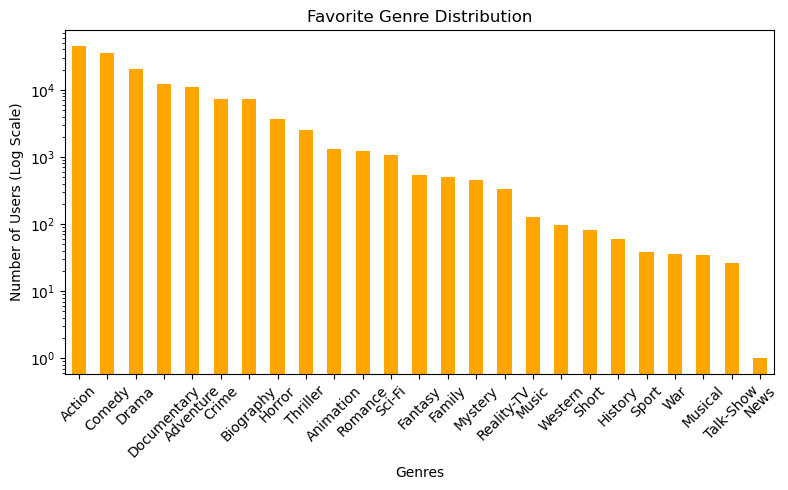

In [52]:
#Let's do a plot to see the favorite genre distribution
counts = dataset_user['fav_genre'].value_counts()

plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='orange')
plt.title('Favorite Genre Distribution')
plt.yscale('log')
plt.xlabel('Genres')
plt.ylabel('Number of Users (Log Scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The really favorite genre of all the user is `action` and the least favorite is `Film-Noir`

##### Second feature: Average click duration

In [11]:
# Creating a new DataFrame with 'user_id' and 'duration' columns
dataset_feature_2 = dataset[['user_id','duration']].copy()

# Grouping by 'user_id' and calculating the mean duration watched by each user
dataset_feature_2 = dataset_feature_2.groupby('user_id').duration.mean().reset_index()

# Assigning a new column 'duration_average' with the mean duration values
dataset_feature_2 = dataset_feature_2.assign(duration_average=dataset_feature_2['duration'])[['user_id', 'duration_average']]

# Merging the dataset_user DataFrame with dataset_feature_2 based on the 'user_id' column
dataset_user = pd.merge(dataset_user, dataset_feature_2, on='user_id')

dataset_user

,user_id,fav_genre,duration_average
0,00004e2862,Crime,0.000000
1,000052a0a0,Action,2024.166667
2,000090e7c8,Mystery,0.000000
3,000118a755,Horror,0.000000
4,000296842d,Drama,11044.000000
...,...,...,...
150958,fffd9bf758,Crime,8495.000000
150959,fffe7b777b,Drama,1785.000000
150960,fffeac83be,Drama,40606.272727
150961,ffff2c5f9e,Action,0.000000


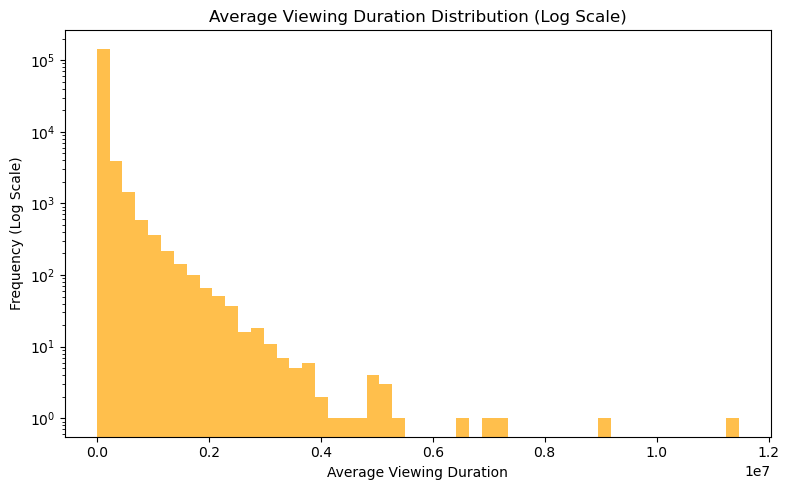

In [53]:
# Let's see now how the average duration is distribuited
ave_dur = dataset_user['duration_average']

# Plot in a log-scale
plt.figure(figsize=(8, 5))
plt.hist(ave_dur, bins=50, color='orange', alpha=0.7)
plt.yscale('log') 
plt.title('Average Viewing Duration Distribution (Log Scale)')
plt.xlabel('Average Viewing Duration')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

We can notice from the plot that there are a lot of users that changes movies fast, in fact `Duration` shows how long it was (in seconds) until that user clicked on another URL

##### Third feature: The most spent time during a day

In [13]:
# Creating a new DataFrame with 'user_id', 'duration', and 'datetime' columns
dataset_feature_3 = dataset[['user_id','duration', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_3.datetime = pd.to_datetime(dataset_feature_3.datetime)

# Function that divide the day in 'Morning', 'Afternoon', 'Night' based on the hours of a day
def categorize_time_of_day(hour):
    if 6 <= hour < 15:
        return 'Morning'
    elif 15 <= hour < 21:
        return 'Afternoon'
    else:
        return 'Night'

# Creating a new column 'time_of_day' using the function created
dataset_feature_3['time_of_day'] = dataset_feature_3.datetime.dt.hour.apply(categorize_time_of_day)

# Grouping by 'user_id' and 'time_of_day' and then we sums the 'duration' for each group
dataset_feature_3 = dataset_feature_3.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# Sorting the dataset to prioritize the highest duration for each user and time of day
dataset_feature_3 = dataset_feature_3.sort_values(by=['user_id', 'duration'], ascending=[True, False])

# Dropping duplicate entries so we have only the highest duration for each user's preferred time of day
dataset_feature_3 = dataset_feature_3.drop_duplicates(subset=['user_id'])

# New column 'preferred_time_of_day'
dataset_feature_3 = dataset_feature_3.assign(preferred_time_of_day=dataset_feature_3['time_of_day'])[['user_id', 'preferred_time_of_day']]

# Merging the dataset_user
dataset_user = pd.merge(dataset_user, dataset_feature_3, on='user_id')

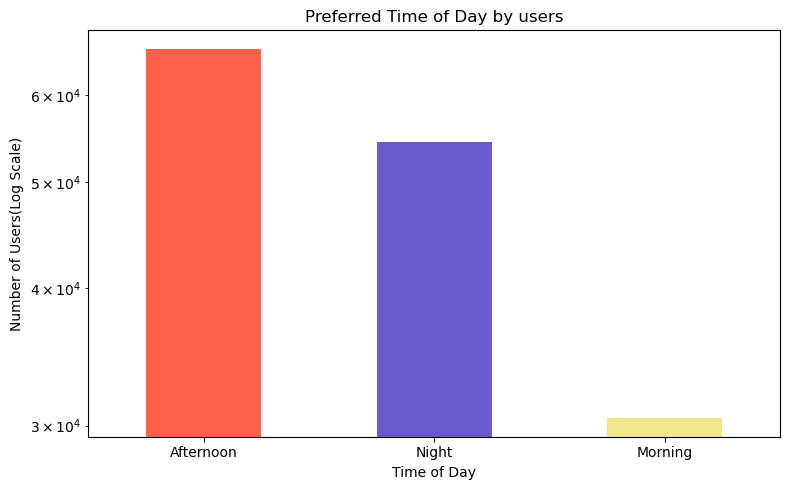

In [54]:
# What is the preferred time of the day that users prefer watching movies?
counts = dataset_user['preferred_time_of_day'].value_counts()

# Plotting Preferred Time of Day (Bar Plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['tomato', 'slateblue', 'khaki'])
plt.title('Preferred Time of Day by users')
plt.yscale('log') 
plt.xlabel('Time of Day')
plt.ylabel('Number of Users(Log Scale)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As we can see most of the users prefers watching movies during the afternoon and the night instead of the morning which is plausible because we can imagine that people goes to school or work during the day (morning).

##### Fourth feature: old movie lover or recent movie lover

In [15]:
# Creating a new DataFrame with 'user_id' and 'release_date' columns
dataset_feature_4 = dataset[['user_id', 'release_date']].copy()

# Converting the 'release_date' column to a pandas datetime format and handling errors with 'coerce'
dataset_feature_4.release_date = pd.to_datetime(dataset_feature_4.release_date, errors='coerce')

# New column 'old_movie' based on the movies released before 2010 or not
dataset_feature_4['old_movie'] = dataset_feature_4['release_date'].dt.year < 2010

# Counting the number of old movies and the total number of movies for each user
old_movie_counts = dataset_feature_4.groupby('user_id')['old_movie'].sum().reset_index()
total_movie_counts = dataset_feature_4.groupby('user_id').size().reset_index(name='total_count')

# Merging these counts by each user
dataset_feature_4 = pd.merge(old_movie_counts, total_movie_counts, on='user_id')

# Determining if a user is an 'old movie lover' based on the proportion of old movies watched
dataset_feature_4['old_movie_lover'] = dataset_feature_4['old_movie'] >= (dataset_feature_4['total_count'] - dataset_feature_4['old_movie'])

# Merging the 'old_movie_lover' information with the dataset_user
dataset_feature_4 = dataset_feature_4[['user_id', 'old_movie_lover']]
dataset_user = pd.merge(dataset_user, dataset_feature_4, on='user_id')

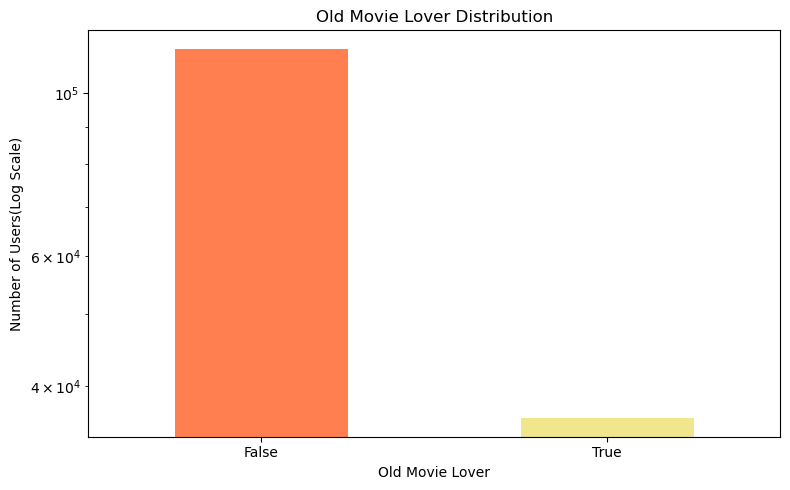

In [55]:
# Let' see the distribution of the old movie lover and not old movie lover
counts = dataset_user['old_movie_lover'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['coral', 'khaki']) 
plt.title('Old Movie Lover Distribution')
plt.yscale('log') 
plt.xlabel('Old Movie Lover')
plt.ylabel('Number of Users(Log Scale)')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

There are much more user that are not old movie lover than the lover ones.

##### Fifth feature : Average time spent a day by the user (considering only the days he logs in)

In [18]:
# Creating a new DataFrame with 'user_id', 'duration', and 'datetime' columns
dataset_feature_5 = dataset[['user_id', 'duration', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_5['datetime'] = pd.to_datetime(dataset_feature_5['datetime'])

# Extracting the date from the 'datetime' column
dataset_feature_5['date'] = dataset_feature_5['datetime'].dt.date

# Grouping by 'user_id' and 'date', calculating the sum of duration for each day, then finding the mean duration per day for each user
dataset_feature_5 = dataset_feature_5.groupby(['user_id', 'date']).duration.sum().groupby('user_id').mean().reset_index()

# Renaming the 'duration' column
dataset_feature_5.rename(columns={'duration': 'average_time_spent_per_day'}, inplace=True)

# Merging
dataset_user = pd.merge(dataset_user, dataset_feature_5, on='user_id')

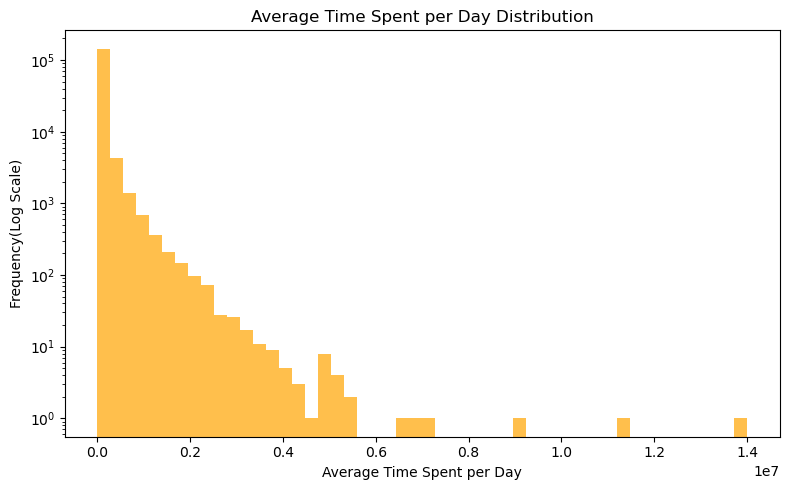

In [56]:
# Let's see how is ditribuited the average time spent by users
ave_time = dataset_user['average_time_spent_per_day']

# Plot
plt.figure(figsize=(8, 5))
plt.hist(ave_time, bins=50, color='orange', alpha=0.7)
plt.title('Average Time Spent per Day Distribution')
plt.yscale('log') 
plt.xlabel('Average Time Spent per Day')
plt.ylabel('Frequency(Log Scale)')
plt.tight_layout()
plt.show()

As we can notice there are many users that even if they log in, in certain day, they log out fast, in the other hand there are some users that every time they log in, they stay logged for a long time in average.

### 2.1.3 Additional 10 features 
Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

##### Sixth feature : Total Number of Unique Movies Watched

Count of total unique movies watched by each user

In [23]:
# Creating a new DataFrame with 'user_id' and 'movie_id' columns
dataset_feature_6 = dataset[['user_id', 'movie_id']].copy()

# Counting the number of unique movies watched by each user
dataset_feature_6 = dataset_feature_6.groupby('user_id')['movie_id'].nunique().reset_index()

# Renaming the 'movie_id' in total_movies_watched
dataset_feature_6.rename(columns={'movie_id': 'total_movies_watched'}, inplace=True)

# Merging
dataset_user = pd.merge(dataset_user, dataset_feature_6, on='user_id')

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1
3,000118a755,Horror,0.000000,Night,True,0.000,1
4,000296842d,Drama,11044.000000,Night,False,38654.000,1
...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2


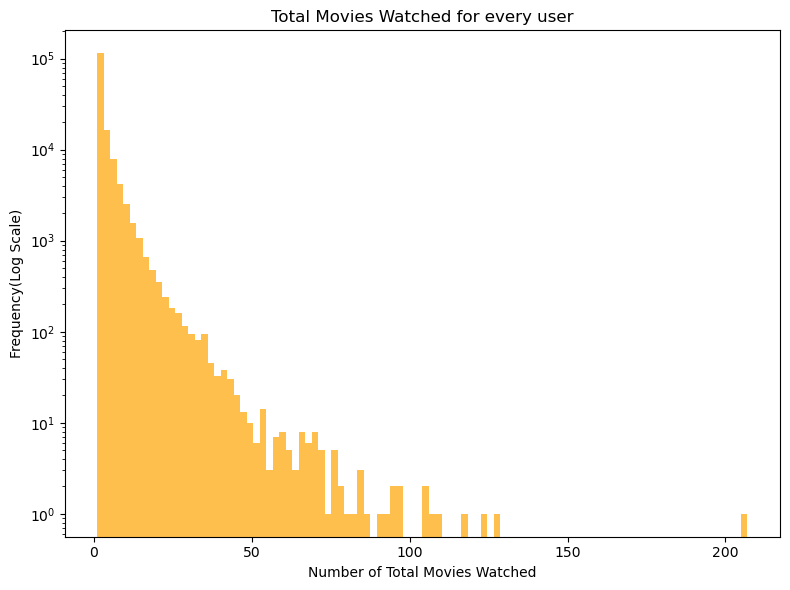

In [57]:
# Let's see the distribution of the total number of movies watched by every user
total_movie = dataset_user['total_movies_watched']

# Plot
plt.figure(figsize=(8, 6))
plt.hist(total_movie, bins=100, color='orange', alpha=0.7)
plt.title('Total Movies Watched for every user')
plt.yscale('log') 
plt.xlabel('Number of Total Movies Watched')
plt.ylabel('Frequency(Log Scale)')
plt.tight_layout()
plt.show()

Notice that there are more users that have watched less than 50 movies than the ones who've watched more than 50.

##### Seventh feature : The favourite movie of a user 


Favourite movie of a user based on the maximum time (duration) spent on watching it.

In [30]:
# Creating a new DataFrame
dataset_feature_7 = dataset[['user_id', 'movie_id', 'title', 'duration']].copy()

# Grouping by 'user_id', 'movie_id', and 'title', then summing the duration for each movie watched by each user
dataset_feature_7 = dataset_feature_7.groupby(['user_id', 'movie_id', 'title'])['duration'].sum().reset_index()

# Finding the movie with the maximum total duration watched by each user
dataset_feature_7 = dataset_feature_7.loc[dataset_feature_7.groupby('user_id')['duration'].idxmax()]

# Renaming the 'title' column to 'favorite_movie'
dataset_feature_7 = dataset_feature_7[['user_id', 'title']].rename(columns={'title': 'favorite_movie'})

# Merging
dataset_user = pd.merge(dataset_user, dataset_feature_7, on='user_id')

dataset_user

##### Eighth feature : Preference of weekday or weekend of the user 

Preference of weekday or weekend of the user based on the occurrences of the logs (datatime).

In [35]:
# Creating a new DataFrame
dataset_feature_8 = dataset[['user_id', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_8['datetime'] = pd.to_datetime(dataset_feature_8['datetime'])

# Extracting the day of the week where 0 is monday ... 6 is sunday
dataset_feature_8['day_of_week'] = dataset_feature_8['datetime'].dt.dayofweek

# Mapping the day of the week to a 'day_category' column ('Weekday' or 'Weekend')
dataset_feature_8['day_category'] = dataset_feature_8['day_of_week'].apply(lambda day: 'Weekday' if day < 5 else 'Weekend')

# After grouping we counts the occurrences of each category
# Reshape the data to have 'Weekday' and 'Weekend' as columns and filling NaN values with 0
dataset_feature_8 = dataset_feature_8.groupby(['user_id', 'day_category']).size().unstack().fillna(0)

# Determining if a user tends to watch more on weekdays or weekends
dataset_feature_8['weekend_or_weekday'] = 'Weekend'
dataset_feature_8.loc[dataset_feature_8['Weekday'] > dataset_feature_8['Weekend'], 'weekend_or_weekday'] = 'Weekday'

# Selecting 'user_id' and 'weekend_or_weekday' columns and resetting the index
dataset_feature_8 = dataset_feature_8['weekend_or_weekday'].reset_index()

# Merging
dataset_user = pd.merge(dataset_user, dataset_feature_8, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday
...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend


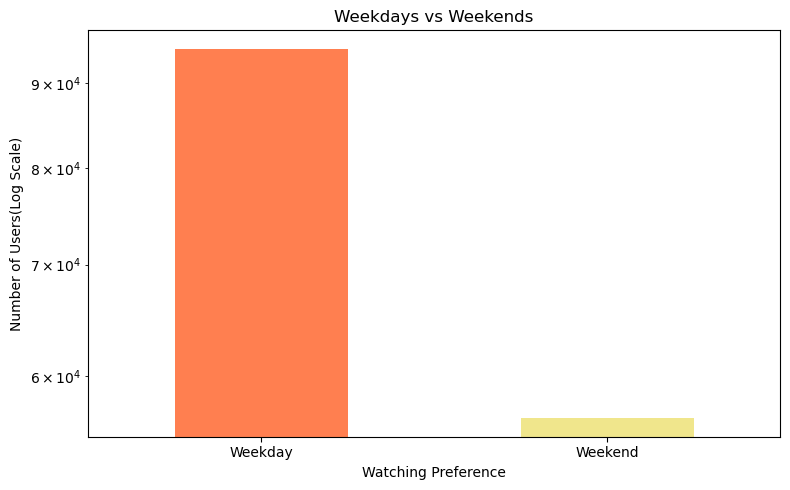

In [58]:
# Distribution of the users preference of watching movies during weekday or weekend
counts = dataset_user['weekend_or_weekday'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['coral', 'khaki'])
plt.title('Weekdays vs Weekends')
plt.yscale('log') 
plt.xlabel('Watching Preference')
plt.ylabel('Number of Users(Log Scale)')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

We suppose that there are more people preferring watching movies during weekdays because the number of days of the weekday are more than the days of the weekend, so there are more chance that a user logs and watches something during the weekdays.

##### Ninth feature : Favourite season to watch movie by a user

Favourite season to watch movie by a user based on the user's behavior, so we look at the occurrences of the logs.

In [39]:
# Creating a new DataFrame
dataset_feature_9 = dataset[['user_id', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_9['datetime'] = pd.to_datetime(dataset_feature_9['datetime'])

# Extracting the month
dataset_feature_9['month'] = dataset_feature_9['datetime'].dt.month

# Mapping the month to a 'season' column so we have 'Winter', 'Spring', 'Summer', 'Autumn'
dataset_feature_9['season'] = dataset_feature_9['month'].apply(lambda month: 'Winter' if month in [12, 1, 2] 
                                                                          else 'Spring' if month in [3, 4, 5] 
                                                                          else 'Summer' if month in [6, 7, 8] 
                                                                          else 'Autumn')

# After grouping we count the occurrences of each season and eshaping the data 
# to have 'Winter', 'Spring', 'Summer', 'Autumn' as columns and filling NaN values with 0
dataset_feature_9 = dataset_feature_9.groupby(['user_id', 'season']).size().unstack().fillna(0)

# Determining the preferred season for each user based on the maximum count of views
dataset_feature_9['preferred_season'] = dataset_feature_9.idxmax(axis=1)

# Selecting 'user_id' and 'preferred_season' columns and resetting the index
dataset_feature_9 = dataset_feature_9['preferred_season'].reset_index()

# Merging
dataset_user = pd.merge(dataset_user, dataset_feature_9, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter
...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer


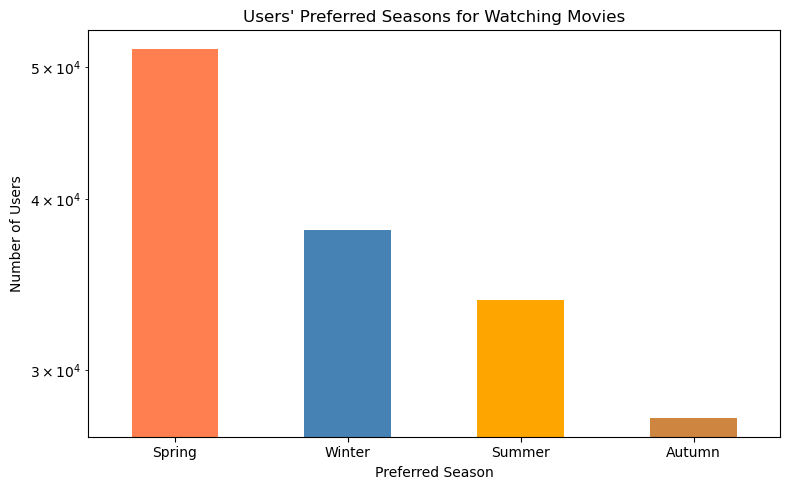

In [43]:
# Let's see the distribution of the preference of the season by users
counts = dataset_user['preferred_season'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['coral', 'steelblue', 'orange', 'peru'])
plt.title('Users\' Preferred Seasons for Watching Movies')
plt.yscale('log') 
plt.xlabel('Preferred Season')
plt.ylabel('Number of Users(Log Scale)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Tenth feature : Number of released movie watched by a user

Number of new released movie watched by a user within a month.

In [44]:
# Creating a new DataFrame 
dataset_feature_10 = dataset[['user_id', 'datetime', 'release_date']].copy()

# Converting 'datetime' and 'release_date' columns to pandas datetime format, handling errors with 'coerce'
dataset_feature_10['datetime'] = pd.to_datetime(dataset_feature_10['datetime'], errors='coerce')
dataset_feature_10['release_date'] = pd.to_datetime(dataset_feature_10['release_date'], errors='coerce')

# Calculating the number of days since the release date of each movie
dataset_feature_10['days_since_release'] = (dataset_feature_10['datetime'] - dataset_feature_10['release_date']).dt.days

# Creating a binary column 'watched_within_month' indicating if a movie was watched within 30 days of its release
dataset_feature_10['watched_within_month'] = dataset_feature_10['days_since_release'].apply(lambda x: 1 if x <= 30 else 0)

# After grouping we sum the 'watched_within_month' to count how many new releases each user watched
dataset_feature_10 = dataset_feature_10.groupby('user_id')['watched_within_month'].sum().reset_index()

# Merging after renaming
dataset_feature_10.columns = ['user_id', 'watched_new_release_count']
dataset_user = pd.merge(dataset_user, dataset_feature_10, on='user_id')

# Fill NaN values with 0 (assuming no new releases were watched if there's no data)
dataset_user['watched_new_release_count'].fillna(0, inplace=True)

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7
...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0


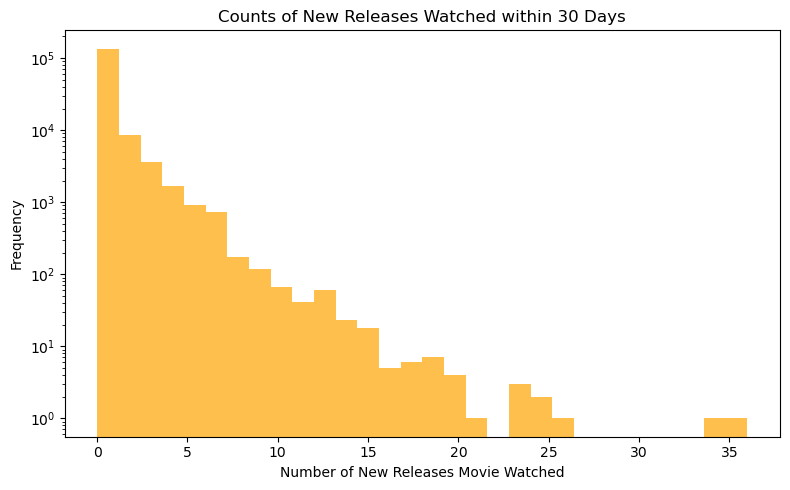

In [49]:
# Let's see the distribution of the numbers of new released movie watched by users
counts = dataset_user['watched_new_release_count']

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='hist', bins=30, color='orange', alpha=0.7)
plt.title('Counts of New Releases Watched within 30 Days')
plt.yscale('log')
plt.xlabel('Number of New Releases Movie Watched')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

Many users don't watch the new released movie within a month or watch less than 10.

##### Eleventh feature : Number of popular movie watched by a user

Number of popular movie watched by a user where a popular movie is a movie with at least 100 clicks. So a user is a popular movie lover if he has watched any popular movie.

In [50]:
# Calculating the click count for each movie to determine popularity
movie_popularity = dataset.groupby('movie_id').size().reset_index()
movie_popularity.columns = ['movie_id', 'click_count']

# Determining if a movie is popular based on a click count threshold (e.g., > 100 clicks)
movie_popularity['is_popular'] = movie_popularity['click_count'] > 100

# Merging the movie popularity information into the original dataset based on 'movie_id'
dataset = pd.merge(dataset, movie_popularity[['movie_id', 'is_popular']], on='movie_id', how='left')

# Creating a new DataFrame
dataset_feature_11 = dataset[['user_id', 'is_popular']].copy()

# Determining if a user is a popular movie lover by checking if they've watched any popular movie
dataset_feature_11['popular_movie_lover'] = dataset_feature_11.groupby('user_id')['is_popular'].transform('any')

# Removing duplicate rows for each user to keep unique user records
dataset_feature_11 = dataset_feature_11.drop_duplicates('user_id')[['user_id', 'popular_movie_lover']].reset_index()

# Converting the 'popular_movie_lover' column to boolean type
dataset_feature_11['popular_movie_lover'] = dataset_feature_11['popular_movie_lover'].astype(bool)

# Selecting specific columns and updating the dataset_user DataFrame based on 'user_id'
dataset_feature_11 = dataset_feature_11[['user_id','popular_movie_lover']]
dataset_user = pd.merge(dataset_user, dataset_feature_11, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True


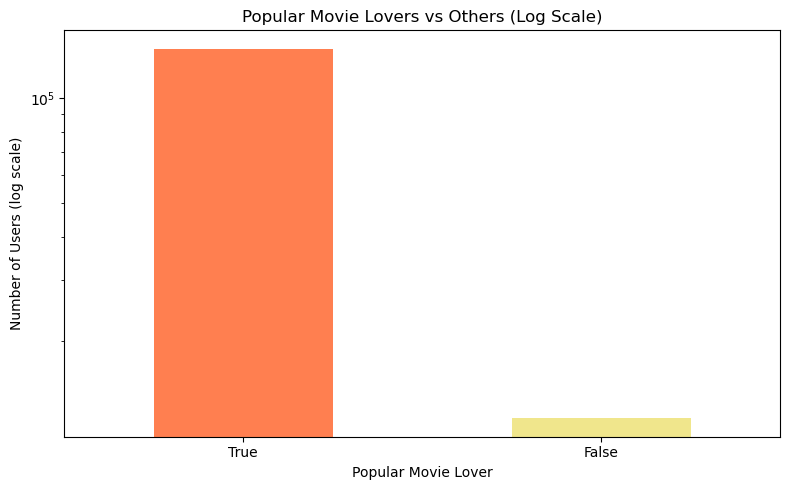

In [51]:
# Let's see the distribution the lovers and not lovers of popular movies
counts = dataset_user['popular_movie_lover'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['coral', 'khaki'])
plt.yscale('log')  
plt.title('Popular Movie Lovers vs Others (Log Scale)')
plt.xlabel('Popular Movie Lover')
plt.ylabel('Number of Users (log scale)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

With this threshold and because we chose that a user is a popular movie lover if he has watched any popular movie, there are a big difference between popular movie lover and not, as we can see there a huge amount of users who likes the popular ones than the not popular ones.

##### Twelfth feature : Average days the user log in during a week

Average days the user log in during a week based on the logs (datetime)

In [59]:
# Creating a new DataFrame 
dataset_feature_12 = dataset[['user_id', 'duration', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_12['datetime'] = pd.to_datetime(dataset_feature_12['datetime'])

# Extracting the day of the week so 0 = Monday ... 6 = Sunday
dataset_feature_12['day_of_week'] = dataset_feature_12['datetime'].dt.dayofweek

# Extracting the date from the 'datetime' column
dataset_feature_12['date'] = dataset_feature_12['datetime'].dt.date

# Calculating the average number of unique days each user engaged with content and taking the mean
user_unique_days = dataset_feature_12.groupby(['user_id', 'date'])['day_of_week'].nunique().groupby('user_id').mean().reset_index()

# Renaming and merging
user_unique_days.columns = ['user_id', 'avg_days_log']
dataset_user = pd.merge(dataset_user, user_unique_days, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0


##### Thirteenth feature : Last interaction of a user

Last interaction of a user based on the datetime column so we are looking at the last log.

In [60]:
# Creating a new DataFrame
dataset_feature_13 = dataset[['user_id', 'datetime']].copy()

# Finding the latest interaction datetime for each user by grouping by 'user_id' and finding the maximum datetime
dataset_feature_13 = dataset.groupby('user_id')['datetime'].max().reset_index()

# Renaming and merging
dataset_feature_13.columns = ['user_id', 'last_interaction']
dataset_user = pd.merge(dataset_user, dataset_feature_13, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43


##### Fourteenth feature : Average gap time between logins of the user

Average gap time between logins of the user based on the datetime column, we are looking at the gap doing the difference between consecutive logs.

In [61]:
# Creating a new DataFrame
dataset_feature_14 = dataset[['user_id', 'datetime']].copy()

# Converting the 'datetime' column to a pandas datetime format
dataset_feature_14['datetime'] = pd.to_datetime(dataset_feature_14['datetime'])

# Sorting the DataFrame by 'user_id' and 'datetime'
dataset_feature_14 = dataset_feature_14.sort_values(['user_id', 'datetime'])

# Calculating the time difference between consecutive interactions for each user
dataset_feature_14['time_diff'] = dataset_feature_14.groupby('user_id')['datetime'].diff().dt.total_seconds()

# Calculating the average time gap between interactions for each user
dataset_feature_14 = dataset_feature_14.groupby('user_id')['time_diff'].mean().reset_index()

# Renaming
dataset_feature_14.columns = ['user_id', 'avg_time_gap']

# Merging and filling any missing values (NaN) with 0
dataset_user = pd.merge(dataset_user, dataset_feature_14, on='user_id').fillna(0)

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15,0.000000
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42,127679.913043
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40,0.000000
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33,0.000000
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23,13211.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32,0.000000
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18,0.000000
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18,363218.600000
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43,1051.000000


##### Fifteenth feature : Number of different genres watched by a user

Number of different genres watched by a user based on the genres_list, we count the different genres a user's watched.

In [64]:
# Creating a new DataFrame 
dataset_feature_15 = dataset[['user_id', 'genres_list']].copy()

# Calculating the count of genres in the 'genres_list' for each user
dataset_feature_15['genre_diversity_count'] = dataset_feature_15['genres_list'].apply(
    lambda x: len(x) if isinstance(x, list) else 0  # Counting the number of genres per user if 'genres_list' is a list
)

# Grouping by 'user_id' and finding the maximum genre diversity count for each user
genre_diversity = dataset_feature_15.groupby('user_id')['genre_diversity_count'].max().reset_index()

# Merging
dataset_user = pd.merge(dataset_user, genre_diversity, on='user_id')

dataset_user

,user_id,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap,genre_diversity_count
0,00004e2862,Crime,0.000000,Afternoon,True,0.000,1,Hannibal,Weekday,Winter,0,True,1.0,2017-12-05 20:39:15,0.000000,3
1,000052a0a0,Action,2024.166667,Afternoon,False,4858.000,11,Resident Evil: Retribution,Weekday,Summer,0,True,1.0,2017-06-26 18:25:42,127679.913043,7
2,000090e7c8,Mystery,0.000000,Afternoon,False,0.000,1,Mute,Weekday,Spring,1,True,1.0,2018-03-09 20:01:40,0.000000,3
3,000118a755,Horror,0.000000,Night,True,0.000,1,The Omen,Weekday,Summer,0,False,1.0,2018-06-14 23:19:33,0.000000,1
4,000296842d,Drama,11044.000000,Night,False,38654.000,1,Black Mirror: Bandersnatch,Weekday,Winter,7,True,1.0,2018-12-31 20:06:23,13211.666667,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,fffd9bf758,Crime,8495.000000,Afternoon,False,8495.000,1,The Fear of 13,Weekday,Summer,0,True,1.0,2017-06-21 18:06:32,0.000000,3
150959,fffe7b777b,Drama,1785.000000,Afternoon,False,1785.000,1,The Circle,Weekend,Summer,0,True,1.0,2017-08-19 17:03:18,0.000000,3
150960,fffeac83be,Drama,40606.272727,Night,False,55833.625,10,Fight Club,Weekday,Summer,0,True,1.0,2017-09-20 21:18:18,363218.600000,4
150961,ffff2c5f9e,Action,0.000000,Afternoon,True,0.000,2,Hot Fuzz,Weekend,Summer,0,True,1.0,2017-07-23 15:02:43,1051.000000,4


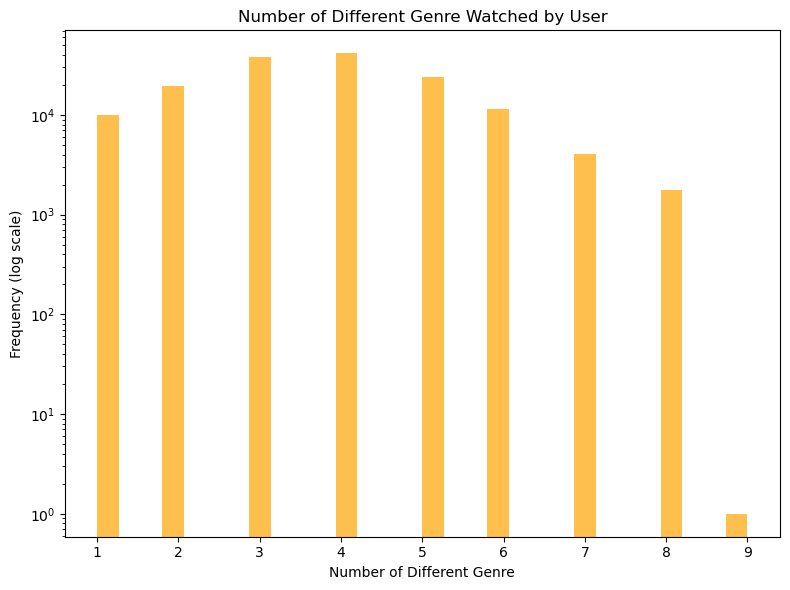

In [67]:
# Let's see the distribution of the diversity genres watched by users
counts = dataset_user['genre_diversity_count']

# Plot
plt.figure(figsize=(8, 6))
plt.hist(counts, bins=30, color='orange', alpha=0.7)
plt.yscale('log')
plt.title('Number of Different Genre Watched by User')
plt.xlabel('Number of Different Genre')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

The number of a different genres watched by users are quite similar from 1 genre to 8 genres watched.

In [28]:
dataset_user.to_csv('dataset_user.csv', index=False)

## 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1.To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

2.Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

### 2.2.1
Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

Our final dataset with the features regarding each user contains a mix of numerical and categorical features, as well as some boolean values, in particulare there are:

- **Numerical features**: 'duration_average', 'average_time_spent_per_day', 'total_movies_watched', 'watched_new_release_count', 'avg_days_log', 'avg_time_gap', 'genre_diversity_count'.
- **Categorical features**: 'fav_genre', 'preferred_time_of_day', 'preferred_season', 'favorite_movie', 'weekend_or_weekday'.
- **Boolean features**: 'old_movie_lover', 'popular_movie_lover'.
- **Other**: user_id (likely a unique identifier for each user), last_interaction (a timestamp).

So because our dataser has mixed data types and our intention is to use algorithms sensitive to scale, like the PCA and the clustering algorithms, normalization of numerical features can be useful because in clustering, for instance, without normalization, a feature with a broad range of values will have a much bigger impact on the formation of clusters than a feature with a narrow range so if the features have different scales, features with larger scales can disproportionately influence the distance calculations, leading to biased or skewed results, so normalizing the data ensures that each feature contributes equally to the distance calculations. Also if we look at the dimensionality reduction, if we perform any of the dimensionality reduction techniques, they aren't inherently sensitive to the scale of the data, but normalizing the data can still be beneficial because it ensures that the variance across features is comparable, which is important because PCA looks for directions that maximize the variance.

**So we decided to normalize the data given the presence of numerical features in your dataset with potentially varying scales and we decided to implement the 'standard normalization' lookink at the "StandardScaler" in the scikit-learn library, which scales the data to have a mean of 0 and a standard deviation of 1.**


In [29]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# load the dataset
dataset_user = pd.read_csv('dataset_user.csv')

# identifying the numerical columns
numerical_columns = dataset_user.select_dtypes(include=['int64', 'float64']).columns

# apply StandardScaler for standarditation
scaler = StandardScaler()
dataset_user_normalized = dataset_user.copy()
dataset_user_normalized[numerical_columns] = scaler.fit_transform(dataset_user[numerical_columns])

# frop the 'user_id' column that is not necessary in this part
dataset_user_normalized = dataset_user_normalized.drop('user_id', axis=1)

# show the dataset normalized
dataset_user_normalized


,fav_genre,duration_average,preferred_time_of_day,old_movie_lover,average_time_spent_per_day,total_movies_watched,favorite_movie,weekend_or_weekday,preferred_season,watched_new_release_count,popular_movie_lover,avg_days_log,last_interaction,avg_time_gap,genre_diversity_count
0,Crime,-0.272538,Afternoon,True,-0.298243,-0.492117,Hannibal,Weekday,Winter,-0.424850,True,0.0,2017-12-05 20:39:15,-0.437252,-0.489912
1,Action,-0.260759,Afternoon,False,-0.274211,1.878195,Resident Evil: Retribution,Weekday,Summer,-0.424850,True,0.0,2017-06-26 18:25:42,-0.123251,2.213155
2,Mystery,-0.272538,Afternoon,False,-0.298243,-0.492117,Mute,Weekday,Spring,0.446892,True,0.0,2018-03-09 20:01:40,-0.437252,-0.489912
3,Horror,-0.272538,Night,True,-0.298243,-0.492117,The Omen,Weekday,Summer,-0.424850,False,0.0,2018-06-14 23:19:33,-0.437252,-1.841446
4,Drama,-0.208269,Night,False,-0.107030,-0.492117,Black Mirror: Bandersnatch,Weekday,Winter,5.677346,True,0.0,2018-12-31 20:06:23,-0.404760,0.185855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150958,Crime,-0.223103,Afternoon,False,-0.256220,-0.492117,The Fear of 13,Weekday,Summer,-0.424850,True,0.0,2017-06-21 18:06:32,-0.437252,-0.489912
150959,Drama,-0.262150,Afternoon,False,-0.289413,-0.492117,The Circle,Weekend,Summer,-0.424850,True,0.0,2017-08-19 17:03:18,-0.437252,-0.489912
150960,Drama,-0.036237,Night,False,-0.022047,1.641164,Fight Club,Weekday,Summer,-0.424850,True,0.0,2017-09-20 21:18:18,0.456006,0.185855
150961,Action,-0.272538,Afternoon,True,-0.298243,-0.255086,Hot Fuzz,Weekend,Summer,-0.424850,True,0.0,2017-07-23 15:02:43,-0.434667,0.185855


In order to **have the dataset every time ready** to work on we chose to **save the dataset after normalization in a 'csv' file** so when we need it we can only reload without running all the previous code

In [30]:
dataset_user_normalized.to_csv('dataset_user_normalized.csv', index=False)

### 2.2.2
Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

**First of all we load the data in order to do our dimensionality reduction**

In [31]:
dataset_user_reduction=pd.read_csv("dataset_user_normalized.csv")

Our dataset is composed of **both numerical and categorical features**, so the first thing we thought of was to apply **FAMD for dimensionality reduction** because it is the technique that automatically takes into account both categorical and numerical variables, but the problem we encountered was the following:
- **The computation was so time consumin**g as some categorical variables in our dataset had many categories and therefore the computational work of the algorithm was so much. In addition, FAMD as a technique is applied through the prince library and therefore the normalisation of the numerical features is done internally, but we had already applied the normalisation to our dataset and therefore it was a lot of work.

We had also thought of considering the categorical and numerical variables separately and applying a dimensionality reduction method to each set of features: the **PCA** for the numerical variables and the **MCA** for the categorical variables, but the problem that arose was always a very large amount of computational time, and even implementing this strategy we noticed through plots that 70% of the variance was explained by 10 out of 15 components examined, which made us say that this was not the right method because 10 components are a lot and it would no longer be dimensionality reduction.

**Another approach we tried was to apply normalisation to the numerical features and then label encoding to the categorical features and then apply PCA** in this case we took into account the complete dataset, at the same time however 99% of the variance was explained with only one principal component and since we are approaching clustering, we then had to identify clusters based on multiple features and therefore if only one component captures most of the variance, we could have lost the ability to distinguish clusters based on other dimensions.

**Given these reasons we decided to use the PCA method only on the numerical features as we realised that in any case the information between the categorical and numerical variables were in many cases linked** e.g. the total number of films a user has seen is linked to favourite genres, average time spent in a day is linked to the features concerning the preferred time of day to look forward and so on. At meantime using only PCA on the numerical feature could cause important information on other categorical features to be lost.

**So we chose to apply the PCA** so we extracted the numerical colums and then we performed the PCA using the default function that is in the 'sklearn' library.
To do this, **we had to choose the right number of components on which to apply PCA**, so to choose correctly, we thought of applying PCA with a number of components equal to the length of the dataset, go and see through a plot the explained variance ration depending on the number of principal components. We chose to **keep the number of principal components that would allow us to capture a large percentage of the total variance, 70%,** and both graphically and analytically **we observed that the number of principal components that had this characteristic was 3 so we applied PCA with 3 components** and got our dataframe after dimensionality reduction

In [32]:
numerical_columns = dataset_user_reduction.select_dtypes(include=['int64', 'float64']).columns
dataset_user_reduction=dataset_user_reduction[numerical_columns]

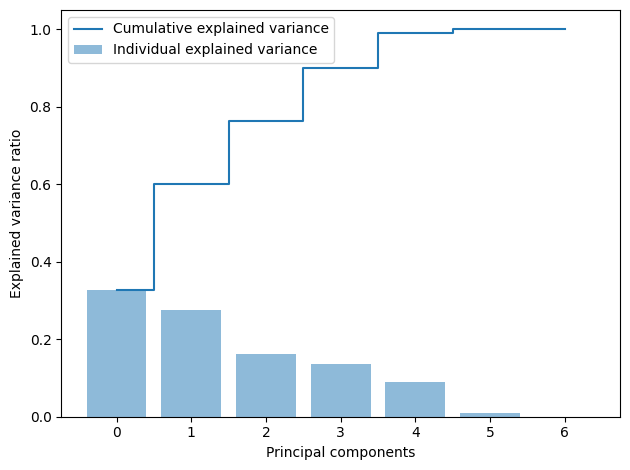

In [33]:
# instantiate PCA
pca = PCA(len(dataset_user_reduction.columns))
# determine transformed features
dataset_user_reduction = pca.fit_transform(dataset_user_reduction)

# determine explained variances and the cumulative sum
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# plot to analyze
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [34]:
# number of components to use
len(cum_sum_eigenvalues[cum_sum_eigenvalues<0.70])+1

3

**We applied the PCA with the 3 components** and even this we decided to save it as a csv file so it would be easier to reuse it

In [35]:
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(dataset_user_reduction)
dataset_user_pca = pd.DataFrame(data = pca_fit, columns = ['PC1', 'PC2','PC3'])
dataset_user_pca.to_csv("dataset_user_pca.csv", index=False)

## 2.3 Clustering!

1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3. Run the algorithm on the data obtained from the dimensionality reduction.

4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

### 2.3.1

Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

**First of all as usual we load the data in order to do our clustering tasks**

In [36]:
dataset_user_for_clustering = pd.read_csv('dataset_user_pca.csv')

We have to implement the K-means algorithm and to do this we decided to use **PySpark**, after installing it in our environment using the command "pip install pyspark" we **initialised a Spark session and converted our previously created dataframe after applying PCA into a spark dataframe.** Now our Spark environment is ready and we can use it.

In [42]:
# initialization of pyspark session
findspark.init()
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "16g").config("spark.executor.memory", "12g").getOrCreate()

# creation of the spark dataset to perform the k-means algorithm
values = dataset_user_for_clustering.values.tolist()
sdf = spark.createDataFrame(values,["PC1","PC2","PC3"])

spark.sparkContext.setLogLevel("ERROR")

The **kmeans_clustering** function effectively utilizes Spark's distributed data processing capabilities to implement the K-means clustering algorithm. Through the MapReduce model:

- **Map Step**: the input DataFrame is first converted to an RDD (Resilient Distributed Dataset), which is a fundamental data structure of Spark that is distributed and fault-tolerant. The map transformation is used to convert each row of the DataFrame into a NumPy array and to distribute these arrays across the cluster for parallel processing.
The distance function, which is another map operation, computes the Euclidean distance between a data point and each centroid, assigning the data point to the nearest centroid.

- **Reduce Step** : After mapping data points to the nearest centroids, the reduceByKey operation (part of the groupByKey and mapValues) aggregates the points by their assigned centroid key and then computes the new centroids by averaging the points in each group. This is a Reduce operation because it takes the distributed data points belonging to the same centroid and combines them to produce a single output (the new centroid).

The function distributes the computation of distances and the recalculation of centroids across a cluster of machines, enabling the processing of large-scale datasets that might not fit into the memory of a single machine. The iterative nature of the algorithm ensures that it converges to a solution where data points are optimally assigned to centroids, forming the desired number of clusters. This custom implementation shows also the usage of Spark's RDD transformations and actions to perform complex data analysis tasks in a parallelized and scalable manner. manner.

In [38]:
def kmeans_clustering(dataset_for_vectorize, k, convergence_threshold=0.01):
    """
    Perform K-means clustering.

    parameter of input:
      - data: Input data as a Spark DataFrame.
      - k:    Number of clusters.
      - convergence_threshold: Threshold for convergence.
    parameter of output: Final centroids, vectorized_rdd and cluster labels.
    """
    # Convert data to RDD and vectorize
    num_partitions = 10 
    vectorized_rdd = dataset_for_vectorize.rdd.map(list).map(lambda row: np.array(row)).repartition(num_partitions)

    # Define the distance function
    def distance(x, y):
        dist = np.zeros(len(y))
        for i in range(len(y)):         
            dist[i] = np.linalg.norm(x-y[i])
        key = np.argmin(dist)
        return (key, x)

    # initialization of the centroids
    init_c = np.array(dataset_for_vectorize.limit(k).collect())
 
    # iterative process
    diff = 999
    while diff > convergence_threshold:
        d = vectorized_rdd.map(lambda row: distance(row, init_c)).repartition(num_partitions)
        updated_c = d.groupByKey().mapValues(lambda row: sum(row) / len(row)).collect()

        K_new = {}
        for i in updated_c:
            K_new[i[0]] = i[1]
        finalist = []
        for i in range(k):
            finalist.append(np.array(K_new[i]))
        final_c = np.array(finalist)

        diff = np.linalg.norm(final_c - init_c)
        init_c = final_c
        
    # cluster labels assignement
    cluster_labels_rdd = vectorized_rdd.map(lambda row: distance(row, init_c)[0])

    final_centroids = init_c
    cluster_labels = cluster_labels_rdd.collect()

    return init_c, vectorized_rdd, cluster_labels

### 2.3.2

Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

we chose to use two different methods to select the optimal clusters:
- **the elbow method**
- **the silhouette score**
We applied both methods via the sklearn library function 'KMeans' and then using the function we created.

Analysing the results obtained in the second elbow method graph, it is not very clear what the elbow point is, but based on these plots, **k=2** seems to be the optimal number of clusters for the following reasons:

- The silhouette score is maximum for **k=2** in both silhouette graphs.
- There is no clear elbow point in the other two plots, indicating that increasing the number of clusters beyond 2 does not significantly improve clustering quality.

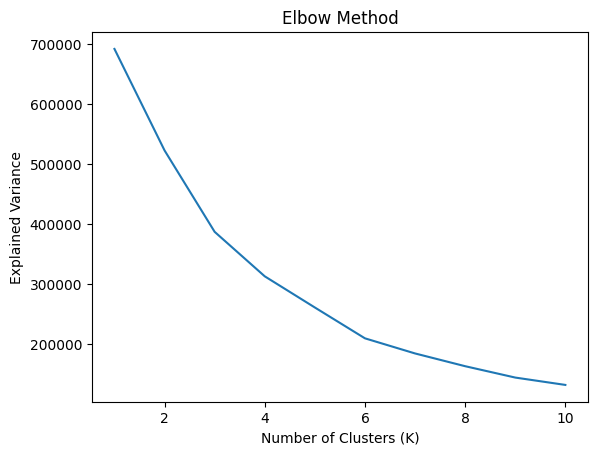

In [39]:
# elbow method using the KMeans function in sklearn

# create a list to store the explained variances
explained_variances = []

# different values of k to try
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(dataset_user_for_clustering)
    explained_variances.append(kmeans.inertia_)

# plot the explained variances - elbow method
plt.plot(k_values, explained_variances)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Explained Variance')
plt.title('Elbow Method')
plt.show()

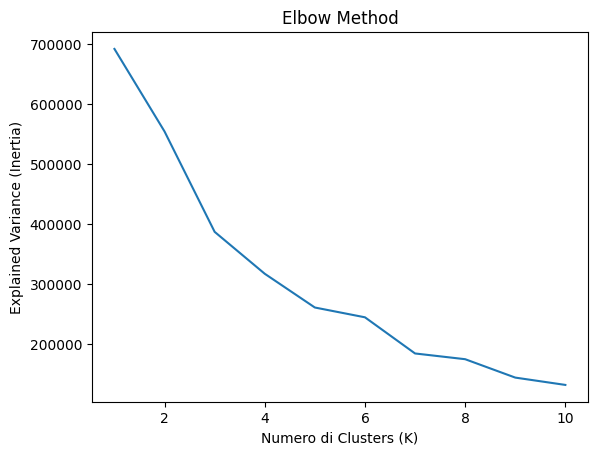

In [40]:
# elbow method using our kmeans function

# create a list to store the explained variances
explained_variances = []

# different values of k to try
k_values = range(1, 11)

# for every value of k in the range perform the k_means custom function 
for k in k_values:
    final_centroids, cluster_vectors, _ = kmeans_clustering(sdf, k)
    distances = cluster_vectors.map(lambda x: np.min(np.linalg.norm(x - final_centroids, axis=1)))
    # Calculate the explained variance as the sum of squared distances
    explained_variance = np.sum([d ** 2 for d in distances.collect()])
    explained_variances.append(explained_variance)

# plot to perform the elbow method
plt.plot(k_values, explained_variances)
plt.xlabel('Numero di Clusters (K)')
plt.ylabel('Explained Variance (Inertia)')
plt.title('Elbow Method')
plt.show()

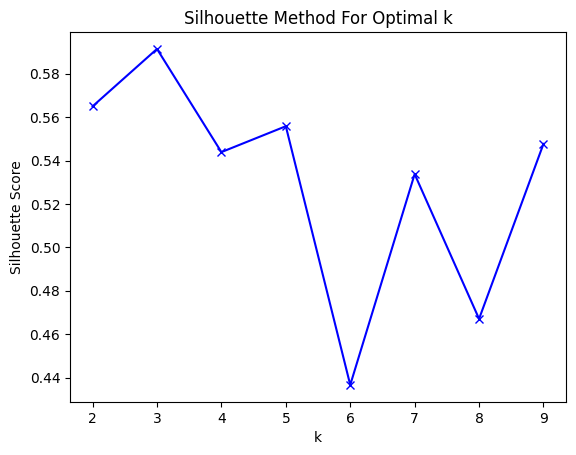

In [44]:
# silhouette score using our kmeans function

def compute_silhouette_score(centroids, rdd):
    def distance(point, centroid):
        return np.linalg.norm(point - centroid)
    
    def find_nearest_cluster(point, centroids, own_cluster):
        distances = [distance(point, centroid) for idx, centroid in enumerate(centroids) if idx != own_cluster]
        return min(distances) if distances else 0

    def compute_point_silhouette(point, centroids, cluster_index):
        own_cluster_distance = distance(point, centroids[cluster_index])
        nearest_cluster_distance = find_nearest_cluster(point, centroids, cluster_index)
        max_distance = max(own_cluster_distance, nearest_cluster_distance)
        if max_distance == 0:  # Avoid division by zero
            return 0
        silhouette = (nearest_cluster_distance - own_cluster_distance) / max_distance
        return silhouette

    # assign points to clusters
    clustered_points = rdd.map(lambda point: (np.argmin([distance(point, centroid) for centroid in centroids]), point))

    # compute silhouette score for each point
    silhouette_scores = clustered_points.map(lambda x: compute_point_silhouette(x[1], centroids, x[0]))

    # calculate the average silhouette score
    average_score = silhouette_scores.mean()
    return average_score

def silhouette_method_custom_kmeans(data, k_range):
    silhouette_values = []
    for k in k_range:
        centroids, rdd, _ = kmeans_clustering(data, k)
        silhouette_avg = compute_silhouette_score(centroids, rdd)
        silhouette_values.append(silhouette_avg)

    # plotting
    plt.plot(k_range, silhouette_values, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

# usage on my spark dataset
silhouette_method_custom_kmeans(sdf, range(2, 10))


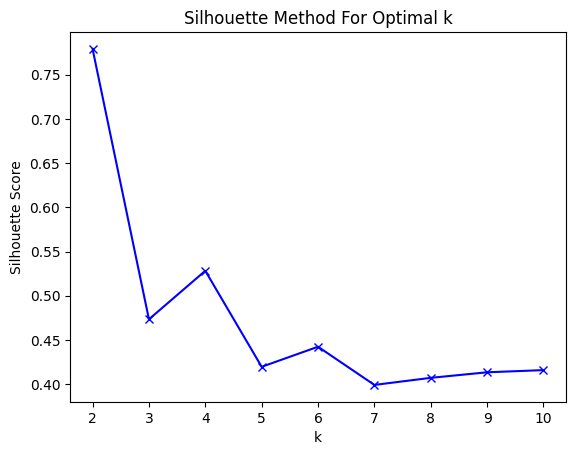

In [45]:
# silhouette score using kmeans sklearn function

# store the values
silhouette_values = []
#range for k
k_range=range(2,11)

# perform the KMeans algorithm from th esklearn library to achieve the score
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(dataset_user_for_clustering)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(dataset_user_for_clustering, labels)
    silhouette_values.append(silhouette_avg)

# plotting the variation of the silhouette score
plt.plot(k_range, silhouette_values, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

### 2.3.3

Run the algorithm on the data obtained from the dimensionality reduction.

**Now after choosing the optimal number od cluster we can compute the k-means algorithm on our dataset**

In [46]:
# optimal number of cluster obtained from the analysis done previously
k = 2

# k-means algorithm on my dataset obtained after the dimensionality reduction
final_centroids, _, _ = kmeans_clustering(sdf, k)
print(final_centroids)

[[ 0.05481644 -0.54205599 -0.12964596]
 [-0.15959062  1.57812223  0.37744657]]


### 2.3.4

Implement K-means++ from scratch and explain the differences with the results you got earlier.

The kmeans_plus_plus_clustering function is the same as the previous function with the only difference that that function begins by initializing cluster centroids using the K-means++ algorithm, which aims to select centroids that are spread out across the dataset. This is more effective than random initialization as we can see by the result as it tends to result in better clustering and faster convergence.

In [47]:
def kmeans_plusplus_init(dataset, k):
    """
    Initialize centroids using K-means++ algorithm.

    parameter of input:
    - dataset: Input data as a NumPy array.
    - k:       Number of clusters.
    parameter of output: Initial centroids as a NumPy array.
    """
    centroids = [dataset[random.randint(0, len(dataset) - 1)]]
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in dataset])
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = random.random()
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(dataset[i])
                break
    return np.array(centroids)

def kmeans_plus_plus_clustering(dataset_for_vectorize, k, convergence_threshold=0.01):
    """
    Perform K-means clustering with K-means++ initialization.

    parameter of input:
    - dataset_for_vectorize: Input data as a Spark DataFrame.
    - k:                     Number of clusters.
    - parameter of convergence_threshold: Threshold for convergence.
    parameter of output: Final centroids, vectorized RDD, cluster labels
    """
    # Convert data to RDD and vectorize
    num_partitions = 10 
    vectorized_rdd = dataset_for_vectorize.rdd.map(list).map(lambda row: np.array(row)).repartition(num_partitions)

    # Initialize centroids using K-means++
    dataset_array = np.array(vectorized_rdd.collect())  # Convert RDD to NumPy array for initialization
    init_c = kmeans_plusplus_init(dataset_array, k)

    # Define the distance function
    def distance(x, y):
        dist = np.zeros(len(y))
        for i in range(len(y)):         
            dist[i] = np.linalg.norm(x-y[i])
        key = np.argmin(dist)
        return (key, x)

    # Iterative process
    diff = 999
    while diff > convergence_threshold:
        d = vectorized_rdd.map(lambda row: distance(row, init_c)).repartition(num_partitions)
        updated_c = d.groupByKey().mapValues(lambda row: sum(row) / len(row)).collect()

        K_new = {}
        for i in updated_c:
            K_new[i[0]] = i[1]
        finalist = []
        for i in range(k):
            finalist.append(np.array(K_new[i]))
        final_c = np.array(finalist)

        diff = np.linalg.norm(final_c - init_c)
        init_c = final_c

    # Assign each point to the nearest cluster and get the cluster labels
    cluster_labels_rdd = vectorized_rdd.map(lambda row: distance(row, init_c)[0])

    # Collect the final centroids and cluster labels
    final_centroids = init_c
    cluster_labels = cluster_labels_rdd.collect()

    return final_centroids, vectorized_rdd, cluster_labels

In [48]:
# optimal number of cluster obtained from the analysis done previously
k = 2

# k-means algorithm on my dataset obtained after the dimensionality reduction
final_centroids, _ ,_ = kmeans_plus_plus_clustering(sdf, k)
print(final_centroids)

[[-1.40522730e-01 -9.09947675e-03  7.70756402e-03]
 [ 7.93167395e+00  5.13611447e-01 -4.35046236e-01]]


### 2.3.5

Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

We asked ChatGPT to recommend another clustering algorithm, he provided us with several including **DBSCAN** and **Agglomerative Hierarchical Clustering** but the former gave us problems as for our dataset there was too much noise in the cluster display and the latter gave us memory problems as it required a lot of memory to be allocated, so we chose **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)** which we learnt was designed specifically for large datasets, which was our case, and goes to build a CF (Clustering Feature) tree for incremental clustering.
We were pleased with the results as we then calculated three different metrics to evaluate this algorithm and compared it with KMeans and noticed that they have more or less the same performance on our dataset (the analysis is above, after the algorithm). This means that the KMeans does a good job on our dataset.

143    31820
149    24843
150     7801
166     6876
218     5088
       ...  
571        1
373        1
673        1
375        1
723        1
Name: count, Length: 730, dtype: int64


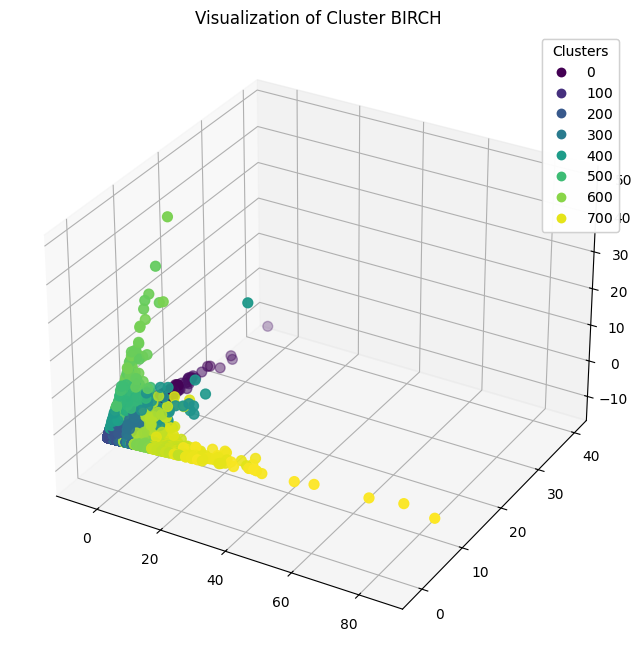

In [53]:
# Load the data
dataset_for_clustering = pd.read_csv('dataset_user_pca.csv')

# inizialitation of BIRCH
# n_clusters=None to give a BIRCH the power to determine the number of cluster
birch_model = Birch(n_clusters=None)

# clustering
birch_model.fit(dataset_for_clustering)

# cluster labels
labels = birch_model.labels_

dataset_for_clustering['cluster_labels'] = labels

# point of each cluster
cluster_counts = pd.Series(labels).value_counts()
print(cluster_counts)

# visualization of the clusters with a scatter plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(dataset_for_clustering['PC1'], dataset_for_clustering['PC2'], dataset_for_clustering['PC3'], c=dataset_for_clustering['cluster_labels'], cmap='viridis', s=50)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('Visualization of Cluster BIRCH')
plt.show()


In [54]:
# K-Means
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans_labels = kmeans.fit_predict(dataset_for_clustering)

# K-Means metrics
kmeans_silhouette = silhouette_score(dataset_for_clustering, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(dataset_for_clustering, kmeans_labels)
kmeans_davies = davies_bouldin_score(dataset_for_clustering, kmeans_labels)

# BIRCH metrics
birch_silhouette = silhouette_score(dataset_for_clustering, labels)
birch_calinski = calinski_harabasz_score(dataset_for_clustering, labels)
birch_davies = davies_bouldin_score(dataset_for_clustering, labels)

# shows the results
print("K-Means - Silhouette Score:", kmeans_silhouette)
print("K-Means - Calinski-Harabasz Score:", kmeans_calinski)
print("K-Means - Davies-Bouldin Score:", kmeans_davies)
print("\nBIRCH - Silhouette Score:", birch_silhouette)
print("BIRCH - Calinski-Harabasz Score:", birch_calinski)
print("BIRCH - Davies-Bouldin Score:", birch_davies)


K-Means - Silhouette Score: 0.8634112721497256
K-Means - Calinski-Harabasz Score: 441310.90149435954
K-Means - Davies-Bouldin Score: 0.34475676472200584

BIRCH - Silhouette Score: 0.8168316121236523
BIRCH - Calinski-Harabasz Score: 19026477.060103584
BIRCH - Davies-Bouldin Score: 0.2801737709217477


## 2.4 Analysing your results! 

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it

 1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.
 2. Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.
 4. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.
 5. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.
 6. Interpret the results for each pivot table.
 7. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.results obtained., and why?

**For our analysis we choose**:
- **DURATION OF WATCHING**
- **TOTAL MOVIE**
- **DIVERSITY GENRE**

Let's have a look at table and after at the observation

In [55]:
# Load the dataset
dataset_user_clustering = pd.read_csv('dataset_user_pca.csv')

In [56]:
# K-Means custom
final_centroids, _, cluster_labels = kmeans_clustering(sdf, k=2)

# add the cluster labels to the dataframe
dataset_user_clustering['cluster'] = cluster_labels

**Load the dataset_user create after the feature engineer to do the pivot table**

In [57]:
dataset_user = pd.read_csv("dataset_user.csv")

**Definition of the functions that splits in 4 categories each of the three features selected for the pitov table**

In [58]:
def class_duration_of_watching(seconds):
    if 0 <= seconds <= 3600:  # Up to 1 hour
        return "0-1"
    elif 3601 <= seconds <= 36000:  # 1 to 10 hours
        return "1-10"
    elif 36001 <= seconds <= 108000:  # 10 to 30 hours
        return "10-30"
    else:  # More than 30 hours
        return ">30"

        
def class_total_movies(movie_count):
    if 0 <= movie_count < 3:  # Between 0 and 2
        return "0-2"
    elif 3 <= movie_count < 6:  # Between 3 and 5
        return "2-5"
    elif 6 <= movie_count < 11:  # Between 6 and 10
        return "5-10"
    else:  # More than 10
        return ">10"

    
def class_diversity_genre(different_genre_count):
    if 0 <= different_genre_count < 2:  # Between 0 and 1
        return "0-1"
    elif 2 <= different_genre_count < 4:  # Between 2 and 3
        return "1-3"
    elif 4 <= different_genre_count < 6:  # Between 4 and 5
        return "3-5"
    else:  # More than 5
        return ">5"


**Using the function above we apply it for each row in the dataset corrisponding to the feature selected**

In [59]:
dataset_user["cluster"] = dataset_user_clustering["cluster"]
dataset_user["duration_of_watching_class"] = dataset_user.duration_average.apply(lambda row: class_duration_of_watching(row))
dataset_user["total_movies_class"] = dataset_user.total_movies_watched.apply(lambda row: class_total_movies(row))
dataset_user["diversity_genre_class"] = dataset_user.genre_diversity_count.apply(lambda row: class_diversity_genre(row))

**Now we are ready to do the pivot table with the information above normalizing as request**

In [60]:
pivot_table_1 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.duration_of_watching_class, values=dataset_user.duration_average, aggfunc="count", normalize="index")*100,1)
pivot_table_2 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.total_movies_class, values=dataset_user.total_movies_watched, aggfunc="count", normalize="index")*100,1)
pivot_table_3 = round(pd.crosstab(index=dataset_user.cluster, columns=dataset_user.diversity_genre_class, values=dataset_user.genre_diversity_count, aggfunc="count", normalize="index")*100,1)

**FIRST PIVOT TABLE: duration_of_watching**

In [61]:
pivot_table_1

duration_of_watching_class,0-1,1-10,10-30,>30
cluster,,,,
0,50.4,28.1,12.2,9.3
1,50.5,28.0,12.2,9.2


**SECOND PIVOT TABLE: total_movies**

In [62]:
pivot_table_2

total_movies_class,0-2,2-5,5-10,>10
cluster,,,,
0,65.1,21.8,8.9,4.3
1,65.0,21.7,8.9,4.3


**THIRD PIVOT TABLE: diversity of genre**

In [63]:
pivot_table_3

diversity_genre_class,0-1,1-3,3-5,>5
cluster,,,,
0,6.7,38.3,43.6,11.4
1,6.7,38.4,43.6,11.4


### OBSERVATION AND INTERPRETATION:

For our pivot table we choose these 3 features:
- **Duration of Watching Class**: This category represent the time users spend watching content, classified into four ranges: 0-1 hours, 1-10 hours, 10-30 hours, and more than 30 hours. The distribution is quite similar across the clusters, because the majority of users (about 50%) in all clusters watch content for 0-1 hour, the next largest group (around 28%) watches between 1 and 10 hours and only smaller percentages of users watch for longer durations, with slightly decreasing percentages as the watching time increases.
- **Total Movies Class**: This category represents the number of movies watched by users, segmented into four ranges: 0-2, 2-5, 5-10, and more than 10 movies. Again, the distribution is fairly consistent across clusters, because most users (about 65%) watch between 0 and 2 movies, making it the most common behavior, around 21% to 22% of users watch between 2 and 5 movies and fewer users watch a larger number of movies, with very small percentages (4% to 5%) watching more than 10 movies.
- **Diversity Genre Class**: This category likely indicates the count of different genres of movies watched by users, categorized into four groups: 0-1, 1-3, 3-5, and more than 5 genres. The clusters show slight variations, a small fraction of users (around 6%) stick to 0-1 genres, a significant proportion of users watch movies in 1-3 genres (about 38% to 39%) and 3-5 genres (about 43% to 45%) and a modest percentage of users (about 10% to 11%) have a diverse watching habit that spans more than 5 genres.

The pivot tables suggest that the user base can be characterized by relatively homogeneous watching habits in terms of duration, the total number of movies watched, and genre diversity. The clusters don't show drastic differences in these aspects, indicating that while users have been segmented into distinct clusters, their behaviors within these categories are quite similar. From a clustering perspective, this could imply that the clustering algorithm has found more nuanced differences between users that may not be captured fully in these categories. Alternatively, it could mean that these particular features do not provide a strong basis for differentiation between clusters.

The results we've obtained from the silhouette_score and calinski_harabasz_score metrics for both the sklearn's KMeans and your custom KMeans implementation show significant differences. Let's analyze these scores both individually and comparatively.

- **Silhouette Score:**

**Sklearn KMeans: 0.7637**

**Custom KMeans: 0.1719**

The silhouette score ranges from -1 to 1. A high silhouette score indicates that the clusters are well-separated and distinct, with data points in each cluster being closer to each other than to points in other clusters. A score closer to 1 is considered good. Sklearn KMeans has a high silhouette score, suggesting good cluster separation and tight clustering. Custom KMeans has a much lower score, indicating that the clusters are not as well-defined and that there might be considerable overlap or the points are not as closely clustered.

- **Calinski-Harabasz Score:**
  
**Sklearn KMeans: 46369.15**

**Custom KMeans: 6287.66**

The Calinski-Harabasz score, also known as the Variance Ratio Criterion, is higher when the clusters are dense and well-separated, which relates to a model with better-defined clusters. There's no upper limit for this score, but a higher value generally indicates better clustering. Sklearn KMeans shows a very high Calinski-Harabasz score, suggesting that the clusters have low intra-cluster variance and high inter-cluster variance, which is desirable. Custom KMeans has a considerably lower score, indicating that the clusters might not be as well-separated and could have higher intra-cluster variance.

**Let's compare the result:**

Sklearn KMeans outperforms the Custom KMeans significantly in both metrics. This suggests that the sklearn implementation of KMeans is resulting in much better clustering for your dataset. The low scores of the Custom KMeans might be due to various factors like the choice of initial centroids, the algorithm used for centroid updating, or other implementation details that differ from the sklearn version.

In conclusion, we can say that the clustering results appear to be moderately satisfactory, the data points within each cluster are more similar to each other than to points in other clusters, but we can surely improve performance.

chieve similar performance.

In [68]:
# Labels extract with the KMeans from Sklearn library
labels = KMeans(n_clusters=2, n_init=10).fit(dataset_user_clustering).labels_

# calculate scores
silhouette_sc = silhouette_score(dataset_user_clustering, labels)
calinski_harabasz_sc = calinski_harabasz_score(dataset_user_clustering, labels)

#showing the results
print("Sklearn K-Means - Silhouette Score:", silhouette_sc)
print("Sklearn K-Means - Calinsky Harabasz:", calinski_harabasz_sc)


Sklearn K-Means - Silhouette Score: 0.7637291255329192
Sklearn K-Means - Calinsky Harabasz: 46369.152127238034


In [71]:
# Our custon KMeans algorithm
_,_, cluster_labels = kmeans_clustering(sdf, k=2)

# scores using our custom KMeans
silhouette_sc_1 = silhouette_score(dataset_user_clustering, cluster_labels)
calinski_harabasz_sc_1 = calinski_harabasz_score(dataset_user_clustering, cluster_labels)

# showing the results
print("Custom K-Means - Silhouette Score:", silhouette_sc_1)
print("Custom K-Means - Calinsky Harabasz: Score", calinski_harabasz_sc_1)

Custom K-Means - Silhouette Score: 0.17194013402895458
Custom K-Means - Calinsky Harabasz: Score 6287.661822990281


## 4. Command Line Question

To do the Command Line Question we utilized Windows Subsystem for Linux (WSL) because of our Windows operating system. This facilitated the utilization of Linux-based commands and tools. 

We considered the dataset with `duration` greater than 0 for the first and third question.

For the first question, we analyzed durations > 0, counted occurrences for each title, and determined the title with the highest count.

For the second, we computed differences in datetime for consecutive clicks by users to find the average time interval between them.

For the third, we have accumulated their time spent on Netflix, and identified the user with the maximum duration.

Everything is available in the file CommandLine.sh and also the screenshot in CommandLine_screenshot


## 5. Algorithmic Question

In [1]:
import numpy as np

## a)

In [2]:
def highest_score_possible(marks, S, n, results_list):
    if n == 0:
        results_list.append(S)
    max_score = S
    for i in range(n):
        new_marks = marks[:]
        current_S = marks[i]

        if S > current_S:
            difference = S - current_S
            new_marks.pop(i)
            new_marks = [element + difference for element in new_marks]
        else:
            difference = current_S - S
            new_marks.pop(i)
            new_marks = [element - difference for element in new_marks]
        max_score = highest_score_possible(new_marks, current_S, n - 1, results_list)
    return max(results_list)

In [3]:
#input 1
marks_list = [5, 7, 1 ]
results_list = []
initial_score = 8
result = highest_score_possible(marks_list, initial_score, len(marks_list), results_list)
print("The highest score possible is: ", result)

The highest score possible is:  11


In [4]:
#input 2
marks_list = [18, 24, 21, 32, 27 ]
results_list = []
initial_score = 25
result = highest_score_possible(marks_list, initial_score, len(marks_list), results_list)
print("The highest score possible is: ", result)

The highest score possible is:  44


In [ ]:
#input 3
marks_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79 ]
results_list = []
initial_score = 30
result = highest_score_possible(marks_list, initial_score, len(marks_list), results_list)
print("The highest score possible is: ", result)

The current algorithm is impractical for a substantial list like the last one provided. In fact, for a list of length 12 (or more), it would take an excessively long time to get an answer. So we need to optimize the code.

### b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

This algorithm's complexity stems from its recursive nature and the exploration of all possible permutations of the marks list. In each recursive call, it checks every possible exam choice, generating a significant number of recursive calls. The number of recursive calls is roughly factorial in nature due to exploring all permutations, which scales rapidly with the length of the marks list. So Federico is right !

### c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

1. **Observation:** After conducting various tests and examining the outcomes, I've observed a consistent trend that seems to hold true for every set of marks in an array.

2. **Algorithm Pattern:**
   - It starts by sorting the list of marks.
   - Then, it divides the sorted list in half, obtaining the higher and lower scores.
   - It calculates the difference between the sum of higher scores and the sum of lower scores.
   - Additionally, if the length of the list is even, it incorporates the initial score.

In [5]:
def highest_score_possible_optimized(marks, S):
    sorted_marks=np.sort(marks)
    bad_grades = sorted_marks[:len(sorted_marks)// 2]
    good_grades = sorted_marks[len(sorted_marks)// 2:]
    final_score = sum(good_grades) - sum(bad_grades) 
    if len(sorted_marks) % 2 == 0:
        final_score+= S 
    return final_score

In [6]:
#input 1
marks_list = [5, 7, 1 ]
initial_score = 8
result = highest_score_possible_optimized(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  11


In [7]:
#input 2
marks_list = [18, 24, 21, 32, 27 ]
initial_score = 25
result = highest_score_possible_optimized(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  44


In [8]:
#input 3
marks_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79 ]
initial_score = 30
result = highest_score_possible_optimized(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  205


### Time complexity:

1. **Sorting the List:**
   - The most computationally expensive step is the sorting operation using `np.sort(marks)`. Its time complexity is O(n log n) for sorting 'n' elements.

2. **Slicing the Sorted List:**
   - After sorting, the algorithm slices the sorted list into two halves: `bad_grades` and `good_grades`. Each slicing operation takes O(n/2) time complexity as it divides the sorted list into two equal halves.

3. **Calculating Final Score:**
   - The algorithm calculates the final score by summing the `good_grades` and subtracting the `bad_grades`, which requires traversing both halves once. This operation has a time complexity of O(n/2) as it sums 'n/2' elements.

4. **Additional Calculation (if applicable):**
   - If the length of the sorted list is even (`len(sorted_marks) % 2 == 0`), it includes the initial score 'S'. This check involves a constant-time operation.

5. **Overall Time Complexity:**
   - The overall time complexity of this algorithm is dominated by the sorting operation so it's O(n log n).


### d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

ChatGPT didn't understand, so I asked for further optimization of the function I provided (highest_score_possible_optimized). It then provided me with the following solution:

In [9]:
def highest_score_possible_chatgpt(marks, S):
    median = np.median(marks)
    good_grades = np.extract(marks >= median, marks)
    bad_grades = np.extract(marks < median, marks)
    
    final_score = np.sum(good_grades) - np.sum(bad_grades)
    
    if len(marks) % 2 == 0:
        final_score += S
    
    return final_score

In [10]:
#input 1
marks_list = [5, 7, 1 ]
initial_score = 8
result = highest_score_possible_chatgpt(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  11


In [11]:
#input 2
marks_list = [18, 24, 21, 32, 27 ]
initial_score = 25
result = highest_score_possible_chatgpt(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  44


In [12]:
#input 3
marks_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79 ]
initial_score = 30
result = highest_score_possible_chatgpt(marks_list, initial_score)
print("The highest score possible is: ", result)

The highest score possible is:  205


### Time complexity:

1. **Calculating the Median:**
   - O(n), where n is the length of the `marks` array, for the calculation of the median using `np.median`.

2. **Extracting Elements Based on the Median:**
   - O(n) time complexity for `np.extract`, as it iterates through the array once to filter elements based on a condition.

3. **Summation of Grades:**
   - Linear time, O(n), to compute the sum of elements in `good_grades` and `bad_grades`.
   
4. **Conditional Check and Addition:**
   - Constant-time operations, O(1), for the conditional check (`if len(marks) % 2 == 0`) and the addition of `S` if the condition is met.

Considering each step operates in O(n) time and there are no nested loops or operations that increase exponentially with n, the overall time complexity of the function is O(n).
